# Implement stable log pdf and parameter gradients of Kumaraswamy

Initial tinkering to find stable implementation

In [1]:
import torch
from torch.autograd import gradcheck
from kumaraswamy import log1mexp, smallest_subnormal_func, KumaraswamyStable#, kumaraswamy_stable_log_pdf
log, exp = torch.log, torch.exp

import matplotlib.pyplot as plt
import numpy as np

from config import FIGURES_DIR

In [ ]:
""" 
class KumaraswamyStableLogPDF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, log_a: torch.Tensor, log_b: torch.Tensor):
        
        log_x = log(x)
        c = exp(log_a) * log_x
        z = log1mexp(- c)
        am1 = torch.expm1(log_a)
        bm1 = torch.expm1(log_b)
        log_pdf = log_a + log_b + am1 * log_x + bm1 * z
        ctx.save_for_backward(log_a, log_b, log_x, am1, bm1, z)

        return log_pdf

    @staticmethod
    def backward(ctx, grad_output):
        log_a, log_b, log_x, am1, bm1, z = ctx.saved_tensors
        a, b = exp(log_a), exp(log_b)
        alpha, beta = exp(- log_a), exp(- log_b)
        x = exp(log_x) + smallest_subnormal_func(log_a.dtype, log_a.device)

        # (b-1) can be negative: -> take log of abs value, and multiply by sign
        nabla_a = alpha + log_x - bm1.sign() * exp( log(bm1.abs()) - z + a * log_x) * log_x
        nabla_b = beta + z
        nabla_x = am1 / x - bm1.sign() * exp( log(bm1.abs()) - z + log_a + am1 * log_x)

        # computation graph: log_a --> a = exp(log_a) --> log_pdf(a)
        # from ddchain rule
        # \nabla_{log_a} log_pdf(a) 
        #  = \nabla_{log_a} a * \nabla_a log_pdf(a) 
        #  = exp(log_a) * \nabla_a log_pdf(a) 
        #  = a * \nabla_a log_pdf(a)
        nabla_log_a = nabla_a * a
        nabla_log_b = nabla_b * b

        grad_x = grad_log_a = grad_log_b = None

        if ctx.needs_input_grad[0]:
            grad_x = grad_output * nabla_x
        if ctx.needs_input_grad[1]:
            grad_log_a = grad_output * nabla_log_a
        if ctx.needs_input_grad[2]:
            grad_log_b = grad_output * nabla_log_b
        
        return grad_x, grad_log_a, grad_log_b #, None, None
"""

In [41]:
class KumaraswamyStableLogPDF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, log_a: torch.Tensor, log_b: torch.Tensor):
        # x \in (0, 1). Cannot be 0 or 1.
        #x = x.clamp(min=)
        # TODO: REMOVE AFTER YOU PLACE THIS CLAMP IN DATA PREPROCESSING
        dtype, device = x.dtype, x.device
        smallest_subnormal = torch.tensor(1.401298464324817e-45, dtype=dtype, device=device) if dtype == torch.float32 else torch.tensor(4.9406564584124654e-324, dtype=dtype, device=device)
        largest_less_than_one = torch.tensor(1 - 2**-24, dtype=dtype, device=device) if dtype == torch.float32 else torch.tensor(1 - 2**-53, dtype=dtype, device=device)
        x = x.clamp(min=smallest_subnormal, max=largest_less_than_one)

        log_x = log(x)
        #c = exp(log_a) * log_x
        alogx = exp(log_a) * log_x
        z = log1mexp(- alogx)
        am1 = torch.expm1(log_a)
        bm1 = torch.expm1(log_b)
        log_pdf = log_a + log_b + am1 * log_x + bm1 * z
        ctx.save_for_backward(log_a, log_b, log_x, am1, bm1, alogx, z, x)

        return log_pdf

    @staticmethod
    def backward(ctx, grad_output):
        log_a, log_b, log_x, am1, bm1, alogx, z, x = ctx.saved_tensors
        b = exp(log_b)
        nabla_log_a = 1 + alogx * (1 - bm1 * exp(alogx - z))
        nabla_log_b = 1 + b * z

        grad_x = grad_log_a = grad_log_b = None

        if ctx.needs_input_grad[0]:
            #nabla_x = am1 / x - bm1.sign() * exp( log(bm1.abs()) - z + log_a + am1 * log_x)
            nabla_x = am1 / x  - bm1 * exp(log_a + am1 * log_x - z)
            grad_x = grad_output * nabla_x
        if ctx.needs_input_grad[1]:
            grad_log_a = grad_output * nabla_log_a
        if ctx.needs_input_grad[2]:
            grad_log_b = grad_output * nabla_log_b
        
        return grad_x, grad_log_a, grad_log_b #, None, None

kumaraswamy_stable_log_pdf = KumaraswamyStableLogPDF.apply

##### Scratchpad

In [181]:
smallest_subnormal =  torch.tensor(2**(-24)) # torch.tensor(1.401298464324817e-45, dtype=torch.float32)
#print(torch.log(smallest_subnormal))
#print(log1mexp(torch.tensor(250)))


# investigating phenomenon of \log_a being driven to 0

def compute_vals(x, log_a, log_b):
    a, b = exp(log_a), exp(log_b)
    print(f"KS({log_a:.2f}, {log_b:.2f}), with data x = {x.item():.8f} --> white pixel")
    alogx = exp(log_a) * log(x)
    z = log1mexp(- alogx)
    log_pdf_ = log_a + log_b + (a-1) * log(x) + (b-1) * z
    print(f"\t alogx: {alogx.item():.2f}")
    print(f"\t log1mexp(alogx): {log1mexp(- alogx).item():.2f}")
    print(f"\t log_pdf_: {log_pdf_.item():.2f}")
    print(f"\t grad_log_a: {(1 + alogx * (1 - (b-1) * exp(alogx - z))).item():.2f}")
    print(f"\t grad_log_b: {(1 + exp(log_b) * z).item():.2f}")


### white pixel
x = torch.tensor(1 - .5/255) # middle of TOP quantized bucket
log_a, log_b = torch.tensor(5), torch.tensor(-.5) # increasing, on 1 = white
compute_vals(x, log_a, log_b)

### black pixel
x = torch.tensor(.5/255) # middle of BOTTOM quantized bucket
# decreasing/sharp bell KS around 0
log_a, log_b = torch.tensor(.15), torch.tensor(7)
compute_vals(x, log_a, log_b)


KS(5.00, -0.50), with data x = 0.99803919 --> white pixel
	 alogx: -0.29
	 log1mexp(alogx): -1.38
	 log_pdf_: 4.75
	 grad_log_a: 0.37
	 grad_log_b: 0.17
KS(0.15, 7.00), with data x = 0.00196078 --> white pixel
	 alogx: -7.24
	 log1mexp(alogx): -0.00
	 log_pdf_: 5.36
	 grad_log_a: -0.57
	 grad_log_b: 0.22


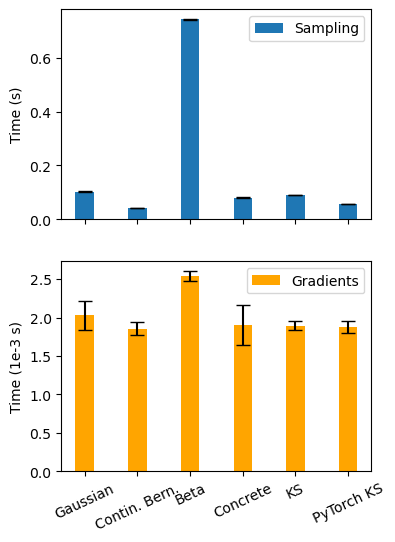

In [ ]:
# Plotting
width = 0.35

# two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
# sampling
rects1 = ax1.bar(distribution_names, sample_means, width, label='Sampling', yerr=sample_stds, capsize=5)
ax1.set_ylabel('Time (s)')
#ax1.set_title('Time for Sampling')
ax1.set_xticks(distribution_names)
ax1.set_xticklabels(distribution_names)
ax1.legend()

# gradient computation
rects2 = ax2.bar(distribution_names, 1e3 * np.array(grad_means), width, label='Gradients', yerr=1e3 * np.array(grad_stds), capsize=5, color='orange')
#ax2.set_xlabel('Distributions')
ax2.set_ylabel('Time (1e-3 s)')
#ax2.set_title('Time for Gradients')
ax2.set_xticks(distribution_names)
ax2.set_xticklabels(distribution_names, rotation=25)
ax2.legend()
# set yticks to [0, 1, 2]
ax2.set_yticks([0, 0.5, 1, 1.5, 2.0, 2.5])


# Save the figure
plt.savefig(FIGURES_DIR + 'sampling_gradient_timing.png', bbox_inches='tight', pad_inches=0.01, dpi=200)
plt.show()

### Numerical Gradient Verification
- Due to the term $\log(1-\exp(a \log x))$, the log pdf and it's parameter gradients become unstable as $a$ grows in magnitude without our log1mexp correction.

See code below, where at $\log a = 15$ there begin to be numerical issues.

In [ ]:
torch.tensor(1, dtype=torch.float32) == (torch.tensor(1, dtype=torch.float32) - torch.tensor(2**-24, dtype=torch.float32))

In [ ]:
smallest_subnormal = torch.tensor(1.401298464324817e-45, dtype=torch.float32)
largest_less_than_one = torch.tensor(1-2**-24, dtype=torch.float32)
print(torch.log(smallest_subnormal))
print(torch.log(largest_less_than_one))

In [ ]:
# Set up the extreme pairs for gradcheck
#log_a = [-10, -10, 10, 10]
#log_b = [-100, 100, -100, 100]
log_a = [-100, -100, 15, 15]
log_b = [-100, 100, -100, 100]
num_repeat = 2000
log_a_values = torch.tensor(log_a * num_repeat, dtype=torch.double, requires_grad=True)
log_b_values = torch.tensor(log_b * num_repeat, dtype=torch.double, requires_grad=True)

# Set up x for gradcheck
eps = 1 - 2**-24
x = torch.linspace(eps, 1-eps, steps=len(log_a_values), dtype=torch.double, requires_grad=False)  # x in (0, 1)

# Display the pairs for inspection
#for log_a, log_b in zip(log_a_values, log_b_values):
#    print(f"(log_a = {log_a.item()}, log_b = {log_b.item()})")

# Perform gradcheck with extreme pairs
input = (x, log_a_values, log_b_values)
test = gradcheck(kumaraswamy_stable_log_pdf, input, eps=1e-2, atol=1e-2)
print(test)  # This should return True if the gradients are correct

x,      f(x), log |nabla_{log_a} log f| , log |nabla_{log_b} log f| * 
0.000,  inf,        2.536,             -0.000
0.000,  0.000,        4.914,             5.618
0.000,  0.000,        4.920,             5.657
0.000,  0.000,        4.924,             5.680
0.000,  0.000,        4.927,             5.697
0.001,  0.000,        4.929,             5.710
0.001,  0.000,        4.931,             5.721
0.001,  0.000,        4.932,             5.730
0.001,  0.000,        4.934,             5.739
0.001,  0.000,        4.935,             5.746
0.001,  0.000,        4.936,             5.753
0.001,  0.000,        4.937,             5.759
0.001,  0.000,        4.937,             5.765
0.001,  0.000,        4.938,             5.770
0.001,  0.000,        4.939,             5.775
0.002,  0.000,        4.939,             5.779
0.002,  0.000,        4.940,             5.784
0.002,  0.000,        4.941,             5.788
0.002,  0.000,        4.941,             5.792
0.002,  0.000,        4.942,         

/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_32199/1119601905.py:36: RuntimeWarning: overflow encountered in exp
  print(f"{x:.3f},  {np.exp(log_pdf_vals).item():.3f},        {grad_a:.3f},             {grad_b:.3f}")
/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_32199/1119601905.py:41: RuntimeWarning: overflow encountered in exp
  pdf = np.exp(log_pdf.detach().numpy())
/var/folders/lk/qxmfz0hx2ggd8m2__sd2ks9h0000gn/T/ipykernel_32199/1119601905.py:42: RuntimeWarning: overflow encountered in exp
  axs[0].plot(x_values.detach().numpy(), np.exp(log_pdf.detach().numpy()), label="pdf f(x)", color='blue')


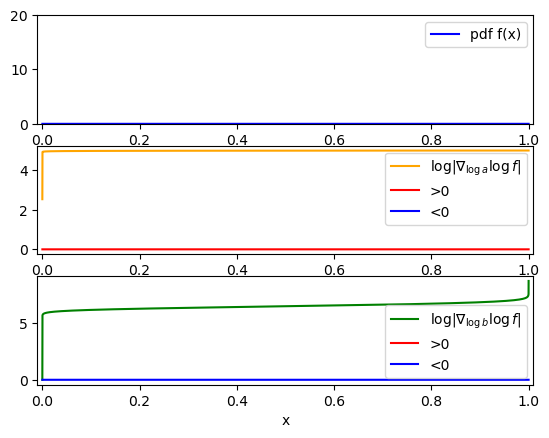

In [142]:
# Set up a range of x values
x_values = torch.linspace(0, 1, steps=10000, dtype=torch.double, requires_grad=True) # x in (0, 1) handled internally

# These must be reshaped so we can compute gradient over EACH x value.
log_a = torch.ones((len(x_values), 1), dtype=torch.double, requires_grad=True)
log_b = torch.ones((len(x_values), 1), dtype=torch.double, requires_grad=True)

### SPECIFY SHAPE of KS ###
log_a_value = -4 #.25
log_b_value = 5 #.5

# Set log_a and log_b to uniform values
log_a = torch.full((len(x_values), 1), log_a_value, dtype=torch.double, requires_grad=True)
log_b = torch.full((len(x_values), 1), log_b_value, dtype=torch.double, requires_grad=True)

x_values_broadcasted = x_values.view(-1, 1)

# Compute the log pdf
log_pdf = kumaraswamy_stable_log_pdf(x_values_broadcasted, log_a, log_b)
np_log_pdf = log_pdf.detach().numpy()

# Compute the gradient with respect to log_a for each x value
log_pdf.backward(torch.ones_like(x_values_broadcasted), retain_graph=True)

# Collect the gradient values
grad_log_a_og = log_a.grad.view(-1).detach().numpy()
grad_log_b_og = log_b.grad.view(-1).detach().numpy()

use_log_magnitude = True
if use_log_magnitude:
    grad_log_a = np.log(np.abs(grad_log_a_og))
    grad_log_b = np.log(np.abs(grad_log_b_og))

print(r"x,      f(x), log |nabla_{log_a} log f| , log |nabla_{log_b} log f| * ")
for i, (x, log_pdf_vals, grad_a, grad_b) in enumerate(zip(x_values, log_pdf.detach().numpy(), grad_log_a, grad_log_b)):
    print(f"{x:.3f},  {np.exp(log_pdf_vals).item():.3f},        {grad_a:.3f},             {grad_b:.3f}")


# Plot the log pdf and its gradient
fig, axs = plt.subplots(3)
pdf = np.exp(log_pdf.detach().numpy())
axs[0].plot(x_values.detach().numpy(), np.exp(log_pdf.detach().numpy()), label="pdf f(x)", color='blue')
axs[0].set_xlabel("x")
if pdf.max() > 20:
    axs[0].set_ylim(0, 20)
axs[0].set_xlim(-1e-2, 1+1e-2)
axs[0].legend()

axs[1].plot(x_values.detach().numpy(), 
            grad_log_a, 
            label=r"$\log |\nabla_{\log a} \log f|$", color='orange')
x_where_nabla_log_a_pos = x_values.detach().numpy()[grad_log_a_og >= 0]
x_where_nabla_log_a_neg = x_values.detach().numpy()[grad_log_a_og < 0]
axs[1].plot(x_where_nabla_log_a_pos, np.zeros_like(x_where_nabla_log_a_pos), color='red', label='>0')
axs[1].plot(x_where_nabla_log_a_neg, np.zeros_like(x_where_nabla_log_a_neg), color='blue', label='<0')

axs[1].set_xlabel("x")
axs[1].set_xlim(-1e-2, 1+1e-2)
axs[1].legend()


axs[2].plot(x_values.detach().numpy(), 
            grad_log_b, 
            label=r"$\log |\nabla_{\log b} \log f|$", color='green')
x_where_nabla_log_b_pos = x_values.detach().numpy()[grad_log_b_og >= 0]
x_where_nabla_log_b_neg = x_values.detach().numpy()[grad_log_b_og < 0]
axs[2].plot(x_where_nabla_log_b_pos, np.zeros_like(x_where_nabla_log_b_pos), color='red', label='>0')
axs[2].plot(x_where_nabla_log_b_neg, np.zeros_like(x_where_nabla_log_b_neg), color='blue', label='<0')
axs[2].set_xlabel("x")
axs[2].set_xlim(-1e-2, 1+1e-2)
axs[2].legend()

## Maximum Likelihood Estimation to Sanity Check

Note that because many of the distributions we test are effectively point masses at 0 or 1, the MLE from samples (which will effectively all be $0$ or $1$) will likely converge to *another* point mass $\delta(0)$ or $\delta(1)$ but who's parameter values are not the same. 

For example, we may sample from $(\log a, \log b) = (2, -10)$ - an 'increasing' shaped distribution which is effectively $\delta(1)$ (all samples will be $=1$), but the MLE may not move toward a bell shaped distribution with $(\log a, \log b) = (30, 80)$.


In [96]:
def shifted_sigmoid(x, lo, hi):
    return lo + (hi - lo) * torch.sigmoid(x)

learning_rate = 1e-1
optim = torch.optim.Adam # torch.optim.SGD
log_a_lims = [0, 5]
log_b_lims = [0, 20]

In [97]:
def mle(samples, log_a_lims, log_b_lims, num_steps=5000):
    # initialize the parameters (poorly) and fit to the data
    stdv = 2
    log_a = (torch.rand(1) * stdv).clone().detach().requires_grad_(True)
    log_b = (torch.rand(1) * stdv).clone().detach().requires_grad_(True)
    optimizer = optim([log_a, log_b], lr=learning_rate)
    grad_log_a_list = []
    grad_log_b_list = []
    for i in range(num_steps):
        optimizer.zero_grad()
        #ks = KumaraswamyStable(log_a, log_b)
        #loss = -ks.log_prob(samples).mean() # mean NLL
        log_a_shifted = shifted_sigmoid(log_a, log_a_lims[0], log_a_lims[1])
        log_b_shifted = shifted_sigmoid(log_b, log_b_lims[0], log_b_lims[1])
        loss = -kumaraswamy_stable_log_pdf(samples, log_a_shifted, log_b_shifted).mean()
        #if i % 1000 == 0:
        #    print(f"inspect gradients")
        loss.backward()
        # extract gradients
        grad_log_a_list.append(log_a.grad.item())
        grad_log_b_list.append(log_b.grad.item())

        optimizer.step()
        if i % 1000 == 0:
            #print(f"\tloss: {loss.item():.3f}, log_a: {log_a.item():.3f}, log_b: {log_b.item():.3f}")
            #log_a_shifted = shifted_sigmoid(log_a, -5, 20)
            #log_b_shifted = shifted_sigmoid(log_b, -10, 60)
            print(f"\tloss: shifted {loss.item():.3f}, log_a: {log_a_shifted.item():.3f}, log_b: {log_b_shifted.item():.3f}")
            # summarize last 10 gradients with their mean
            print(f"\t\tAve. grad log_a: {np.mean(grad_log_a_list[-10:]):.3f}, Ave. grad log_b: {np.mean(grad_log_b_list[-10:]):.3f}")
    # recovered parameters
    return log_a_shifted, log_b_shifted


### Inspect Samples. See that they are all exactly $0$ or $1$ for many distributions.

In [98]:
# compute the bit representation of each float32 in pytorch tensor
def float32_to_bit_components(tensor):
    # Ensure the input tensor is of type float32
    if tensor.dtype != torch.float32:
        raise ValueError("Input tensor must be of type float32.")
    
    # Convert the float32 tensor to int32 tensor using the view method
    int_repr = tensor.view(torch.int32)
    
    bit_components = []
    
    for num in int_repr:
        # Convert to a 32-bit binary string
        bit_string = f'{num:032b}'
        
        # Extract the sign bit, exponent, and mantissa
        sign_bit = bit_string[0]
        exponent = bit_string[1:9]
        mantissa = bit_string[9:]
        
        bit_components.append((sign_bit, exponent, mantissa))
    
    return bit_components

### Run MLE

In [ ]:
fit_shape = 'bell'

if fit_shape == 'increasing':
    #log_a, log_b = 5, -2
    log_a, log_b = 2, -15 # effectivelly everything is exactly 1
elif fit_shape == 'decreasing':
    log_a, log_b = -1, 10 # effectivelly everything is exactly 0
elif fit_shape == 'bell':
    log_a, log_b = 4, 30
elif fit_shape == 'U':
    log_a, log_b = -10, -3

mle_dtype = torch.float32
log_a = torch.tensor(log_a, dtype=mle_dtype)
log_b = torch.tensor(log_b, dtype=mle_dtype)
print(f"Sampling data from Kumaraswamy distribution with log_a = {log_a.item()}, log_b = {log_b.item()}")

# Generate some data from the following Kumaraswamy distribution
ks = KumaraswamyStable(log_a, log_b)
torch.manual_seed(5)
samples = ks.sample((5000,))

# for stable log-pdf, clamp the samples to be in (0, 1)
dtype, device = x.samples, x.samples
smallest_subnormal = torch.tensor(1.401298464324817e-45, dtype=dtype, device=device) if dtype == torch.float32 else torch.tensor(4.9406564584124654e-324, dtype=dtype, device=device)
largest_less_than_one = torch.tensor(1 - 2**-24, dtype=dtype, device=device) if dtype == torch.float32 else torch.tensor(1 - 2**-53, dtype=dtype, device=device)
samples = samples.clamp(min=smallest_subnormal, max=largest_less_than_one)

# Check if these are exactly 0 or 1
float32_to_bit_components(samples)

In [100]:
print(f"Performing Maximum Likelihood Estimation to recover the parameters...")
mle_log_a, mle_log_b = mle(samples, log_a_lims=log_a_lims, log_b_lims=log_b_lims, num_steps=50000)

# Inspect the recovered parameters
print(f"\tRecovered log_a: {mle_log_a.item()}, log_b: {mle_log_b.item()}")
recovered_ks = KumaraswamyStable(log_a, log_b)

Performing Maximum Likelihood Estimation to recover the parameters...
	loss: shifted -0.617, log_a: 3.583, log_b: 16.646
		Ave. grad log_a: 18.625, Ave. grad log_b: -2.679
	loss: shifted -2.874, log_a: 3.586, log_b: 19.884
		Ave. grad log_a: -0.000, Ave. grad log_b: -0.003
	loss: shifted -2.876, log_a: 3.591, log_b: 19.964
		Ave. grad log_a: 0.005, Ave. grad log_b: -0.001
	loss: shifted -2.876, log_a: 3.589, log_b: 19.984
		Ave. grad log_a: -0.102, Ave. grad log_b: -0.000
	loss: shifted -2.876, log_a: 3.593, log_b: 19.992
		Ave. grad log_a: -0.001, Ave. grad log_b: -0.000
	loss: shifted -2.875, log_a: 3.595, log_b: 19.995
		Ave. grad log_a: 0.092, Ave. grad log_b: -0.000
	loss: shifted -2.876, log_a: 3.594, log_b: 19.997
		Ave. grad log_a: 0.044, Ave. grad log_b: -0.000
	loss: shifted -2.877, log_a: 3.590, log_b: 19.998
		Ave. grad log_a: -0.060, Ave. grad log_b: -0.000
	loss: shifted -2.877, log_a: 3.590, log_b: 19.999
		Ave. grad log_a: -0.119, Ave. grad log_b: -0.000
	loss: shifted 

### How different are the recovered distributions? Parameters may differ, but what about KL?

In [81]:
# Estimate the KL divergence between the true and recovered distributions
sample_true = ks.sample((10000,))
sample_recovered = recovered_ks.sample((10000,))
kl_true_recovered = (ks.log_prob(sample_true) - recovered_ks.log_prob(sample_true)).mean()
kl_recovered_true = (recovered_ks.log_prob(sample_recovered) - ks.log_prob(sample_recovered)).mean()
print(f"KL Div. Between True and Recovered: {kl_true_recovered.item():.5f}")
print(f"KL Div. Between Recovered and True: {kl_recovered_true.item():.5f}")
print(f"Ave. KL Div.: {(kl_true_recovered + kl_recovered_true) / 2:.5f}")

# find prob of true samples < .05, > .95
p_true_less_than_05 = ks.cdf(torch.tensor(0.05))
p_true_greater_than_95 = 1 - ks.cdf(torch.tensor(0.95))
p_recovered_less_than_05 = recovered_ks.cdf(torch.tensor(0.05))
p_recovered_greater_than_95 = 1 - recovered_ks.cdf(torch.tensor(0.95))
print(f"True: P(X < 0.05) = {p_true_less_than_05.item():.3f}, P(X > 0.95) = {p_true_greater_than_95.item():.3f}")
print(f"Recovered: P(X < 0.05) = {p_recovered_less_than_05.item():.3f}, P(X > 0.95) = {p_recovered_greater_than_95.item():.3f}")

KL Div. Between True and Recovered: 0.00000
KL Div. Between Recovered and True: 0.00000
Ave. KL Div.: 0.00000
True: P(X < 0.05) = 0.000, P(X > 0.95) = 0.000
Recovered: P(X < 0.05) = 0.000, P(X > 0.95) = 0.000


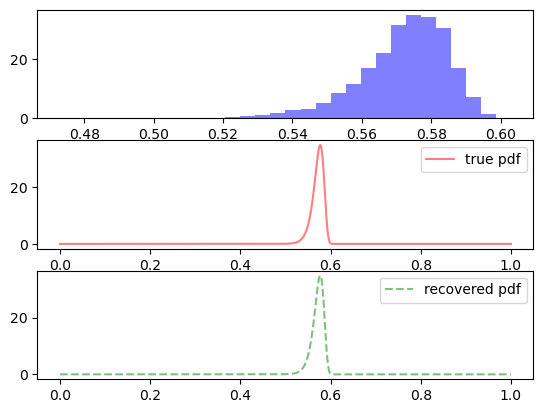

In [82]:
# make 2 subplots, one for the samples from the true pdf, the other comaring the true and recovered pdfs
fig, axs = plt.subplots(3)
axs[0].hist(samples.numpy(), bins=30, density=True, color='blue', alpha=0.5, label="samples")
x = torch.linspace(0, 1, steps=2000)
pdf = ks.log_prob(x).exp()
recovered_pdf = recovered_ks.log_prob(x).exp()

# for plotting purposes in non-log space, replace inf with largest non-inf value
pdf[pdf == float('inf')] = pdf[pdf != float('inf')].max()
recovered_pdf[recovered_pdf == float('inf')] = recovered_pdf[recovered_pdf != float('inf')].max()

axs[1].plot(x.numpy(), pdf, color='red', label=f"true pdf", alpha=0.5)
axs[1].legend()

axs[2].plot(x.numpy(), recovered_pdf, color='green', label=f"recovered pdf", alpha=0.5, linestyle='--')
axs[2].legend()
plt.show()